In [59]:
import os
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from xhistogram.xarray import histogram
import pandas as pd
import cartopy.crs as ccrs

url_base = 'https://thredds.met.no/thredds/dodsC/ww3_4km_archive_files/%Y/%m/%d/ww3_4km_%Y%m%dT00Z.nc'

In [60]:
def open_mfdataset_overlap(url_base, time_series, timedim='time', variables=None):
    urls = [t.strftime(url_base) for t in time_series]
    time_step = time_series[1] - time_series[0]
    print('Opening individual URLs...')
    #datasets = [xr.open_dataset(u, chunks='auto').sel({timedim: slice(t, t+time_step-timedelta(seconds=1))})
    #            for u,t in zip(urls, time_series)]
    datasets = []
    for u, t in zip(urls, time_series):
        try:
            print(f'Opening {u}')
            d = xr.open_dataset(u, chunks='auto').sel({timedim: slice(t, t+time_step-timedelta(seconds=1))})
            if variables is not None:
                try:
                    d = d[variables]
                except Exception as e:
                    raise ValueError(f'Not containing relevant variables: {e}')
            datasets.append(d)
        except:
            print(f'Could not open {u}')

                                                      
    print('Concatenating...')    
    ds = xr.concat(datasets, dim=timedim,
                data_vars='minimal',
                   compat='override', combine_attrs='override', join='override', coords='all')
    return ds

baltic {'rlat': slice(400, 620, None), 'rlon': slice(400, 630, None)}
Opening individual URLs...
Opening https://thredds.met.no/thredds/dodsC/ww3_4km_archive_files/2022/06/01/ww3_4km_20220601T00Z.nc
Opening https://thredds.met.no/thredds/dodsC/ww3_4km_archive_files/2022/06/02/ww3_4km_20220602T00Z.nc
Concatenating...


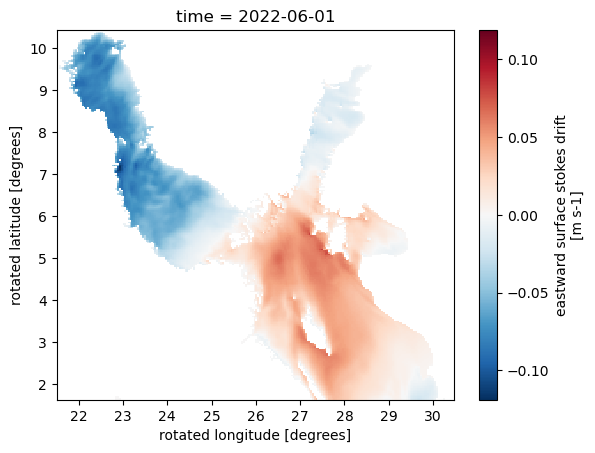

bergen {'rlat': slice(300, 400, None), 'rlon': slice(250, 400, None)}
Opening individual URLs...
Opening https://thredds.met.no/thredds/dodsC/ww3_4km_archive_files/2022/06/01/ww3_4km_20220601T00Z.nc
Opening https://thredds.met.no/thredds/dodsC/ww3_4km_archive_files/2022/06/02/ww3_4km_20220602T00Z.nc
Concatenating...


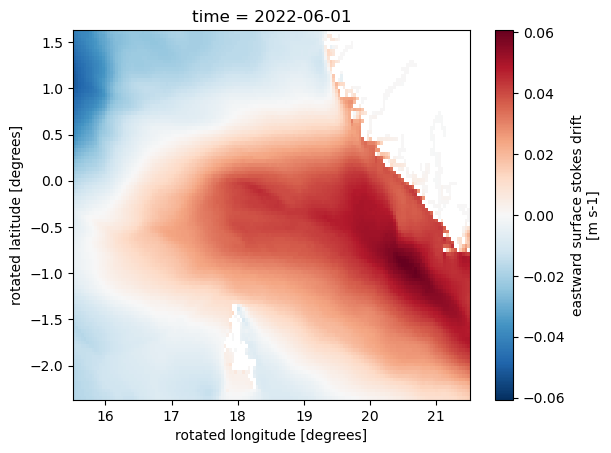

In [61]:
areas = {
    'baltic': {'rlat': slice(400, 620), 'rlon': slice(400, 630)},
    'bergen': {'rlat': slice(300, 400), 'rlon': slice(250, 400)},
}
for an, a in areas.items():
    print(an, a)
    dr = pd.date_range(start='2022-06-01', end='2022-06-02')
    ds = open_mfdataset_overlap(url_base, dr, variables=['uuss', 'vuss', 'uwnd', 'vwnd'])
    ds = ds.isel(**a)
    ds.uuss.isel(time=0).plot()
    plt.show()

In [75]:
for an, a in areas.items():
    outfile = f'{an}_wind_stokes.nc'
    if not os.path.exists(outfile):
        dr = pd.date_range(start='2022-06-01', end='2022-06-03')
        ds = open_mfdataset_overlap(url_base, dr, variables=['uuss', 'vuss', 'uwnd', 'vwnd'])
        print(ds)
        dsub = ds.isel(**a)
        stokes = np.sqrt(dsub.uuss**2 + dsub.vuss**2).rename('stokes_drift')
        wind_speed = np.sqrt(dsub.uwnd**2 + dsub.vwnd**2).rename('wind_speed')
        c = xr.merge([stokes, wind_speed, dsub.uwnd.rename('x_wind'), dsub.vwnd.rename('y_wind')])
        c.to_netcdf(outfile)
    else:
        print(f'Importing from {outfile}')
        c = xr.open_dataset(outfile, chunks={'time': 1})
        
    outfile_mean = f'{an}_mean.nc'
    if not os.path.exists(outfile_mean) or True:
        sr = c.stokes_drift/c.wind_speed*100
        sr = sr.where(sr>0)
        sr = sr.where(sr<10)
        stw = sr.where(c.x_wind<0).mean(dim='time').rename('stokes_westwards_wind')
        ste = sr.where(c.x_wind>0).mean(dim='time').rename('stokes_eastwards_wind')
        stm = sr.mean(dim='time').rename('stokes_mean')
        xr.merge([ste, stw, stm]).to_netcdf(outfile_mean)

Importing from baltic_wind_stokes.nc
Importing from bergen_wind_stokes.nc


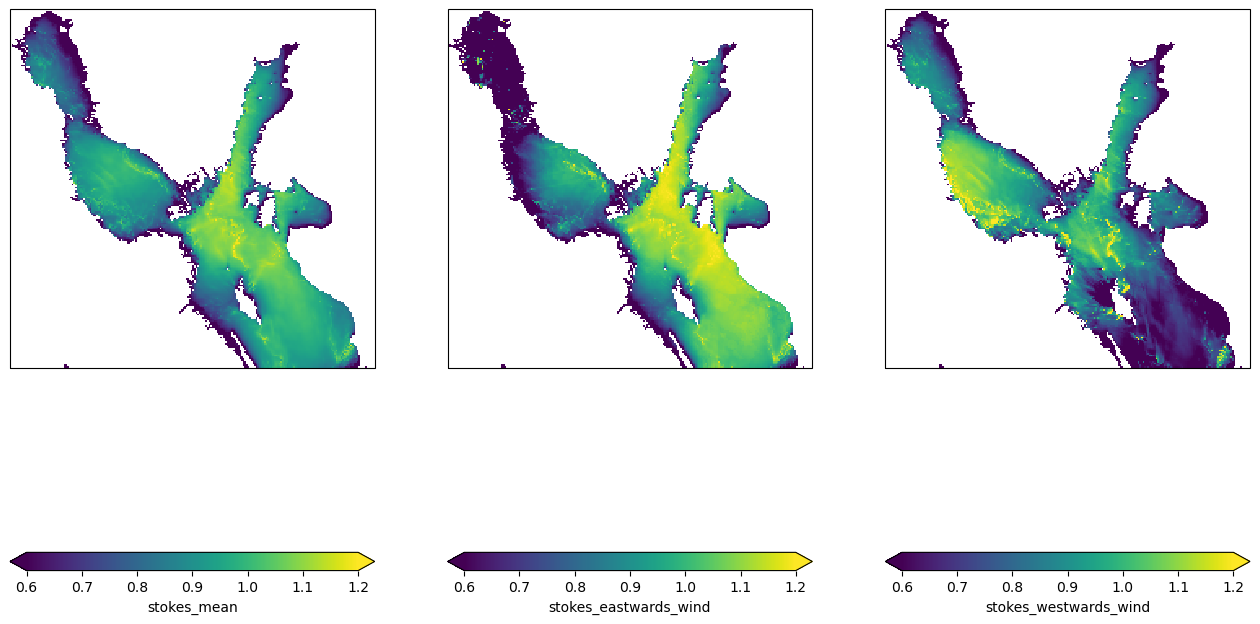

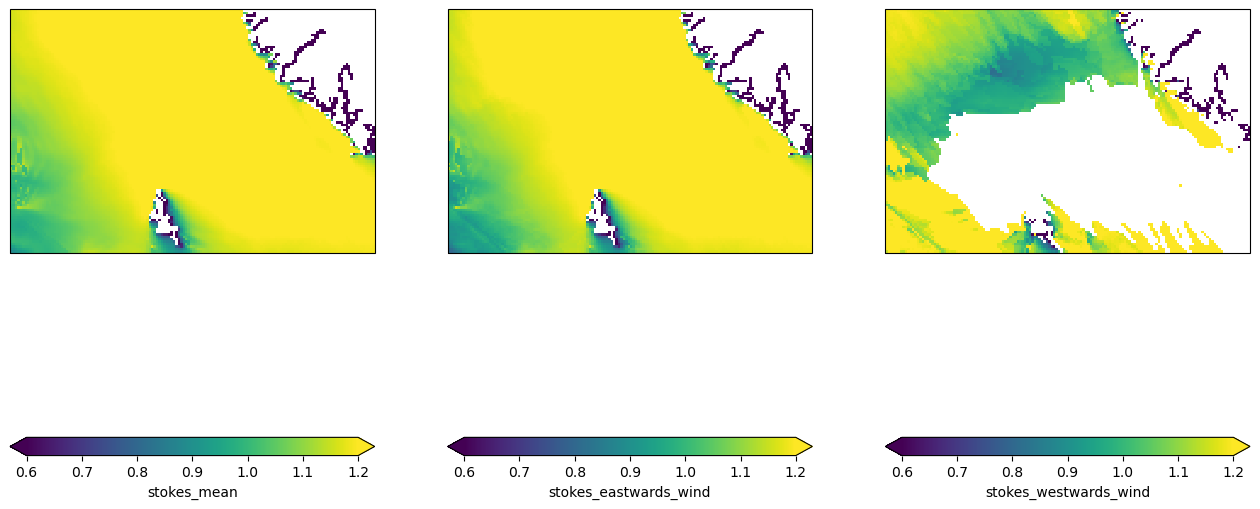

In [80]:
for an, a in areas.items():
    outfile_mean = f'{an}_mean.nc'
    s = xr.open_dataset(outfile_mean)
    ste = s.stokes_eastwards_wind
    stw = s.stokes_westwards_wind
    stm = s.stokes_mean
    
    fig, (axm, axe, axw) = plt.subplots(nrows=1, ncols=3,
                                subplot_kw={"projection": ccrs.Mercator()}, figsize=(16,16))
    cbar_kwargs={'orientation':'horizontal'}
    stm.plot(vmin=0.6, vmax=1.2, ax=axm, cbar_kwargs=cbar_kwargs)
    ste.plot(vmin=0.6, vmax=1.2, ax=axe, cbar_kwargs=cbar_kwargs)
    stw.plot(vmin=0.6, vmax=1.2, ax=axw, cbar_kwargs=cbar_kwargs)

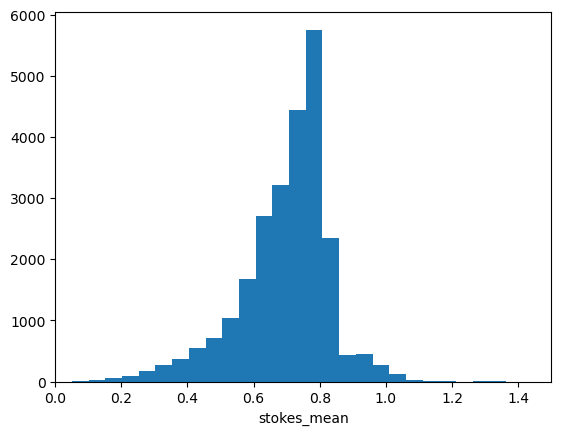

In [14]:
bins_w = np.linspace(0, 25, 100)
bins_s = np.linspace(0, 5, 100)
stm.plot.hist(bins=bins_s)
plt.xlim([0, 1.5])
plt.show()

wind_speed Stokes drift ratio
<xarray.DataArray 'wind_speed' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray> <xarray.DataArray 'Stokes drift ratio' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>


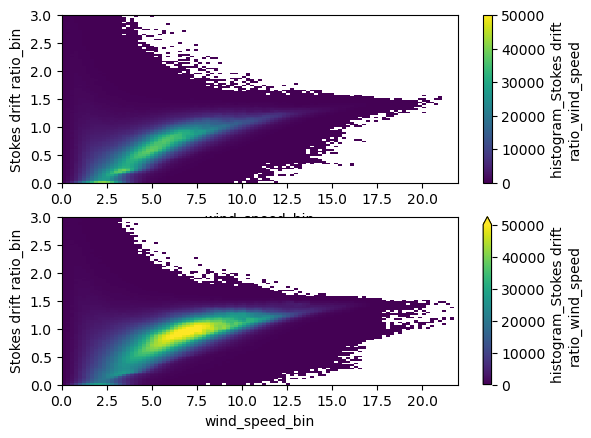

In [28]:
wind_speed = c.wind_speed
sr = c.stokes_drift/c.wind_speed*100
sr = sr.rename('Stokes drift ratio')
print(wind_speed.name, sr.name)
bins_w = np.linspace(0, 22, 100)
bins_s = np.linspace(0, 3, 100)
print(wind_speed.mean(), sr.mean())
#fig, (axe, axw) = plt.subplots(ncols=2, nrows=1)
plt.subplot(2,1,1)
h = histogram(sr.where(c.x_wind<0), wind_speed.where(c.x_wind<0), bins=[bins_s, bins_w])
h.where(h>0).plot(vmin=0, vmax=50000)
plt.subplot(2,1,2)
h = histogram(sr.where(c.x_wind>0), wind_speed.where(c.x_wind>0), bins=[bins_s, bins_w])
h.where(h>0).plot(vmin=0, vmax=50000)

In [ ]:
#h = histogram(sr, wind_change, bins=[bins_s, np.linspace(-2, 2, 100)])
#h.where(h>0).plot(vmin=0, vmax=100)
#plt.ylim([0, 2])
#plt.show()